# Salary Prediction

author = Gindely Duran
<br>
email = gindely.duran@gmail.com

## Introduction

A relatively new company would like to predict employees' annual salary based on specific attributes in order to make competitive job offers to new hires. 

### Dataset

The data includes 1,000,000 observations and the following variables:

**jobId:** Unique identifier for each employee
<br>
**salary:** fixed payment per year
<br>
**companyId:** Identifier for each company
<br>
**jobType:** Position held within the company (CEO, CFO, CTO, Vice President, Manager, Janitor, Senior, or Junior)
<br>
**degree:** educational degree (Doctoral, Masters, Bachelors, High School, or None) 
<br>
**major:** concentration of study
<br>
**industry:** general field of work
<br>
**yearsExperience:** how many years of work experience
<br>
**milesFromMetropolis:** how many miles away the job is from a major city

In [1]:
#import libraries
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib


## DISCOVER

In [2]:
#load the data into a dataframe
df_train_salaries = pd.read_csv('train_salaries.csv')
df_train_features = pd.read_csv('train_features.csv')
df_test_features = pd.read_csv('test_features.csv')

### Examine the data

In [3]:
df_train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [4]:
df_train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [5]:
df_test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [6]:
#see lengths and data types
df_train_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [7]:
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [8]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


### Data Cleaning

In [9]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
df_train_salaries.duplicated().sum()

0

In [10]:
df_train_features.duplicated().sum()

0

In [11]:
df_test_features.duplicated().sum()

0

In [12]:
#merge datasets on job id
df_train = pd.merge(df_train_salaries, df_train_features, on="jobId")
df_train.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [13]:
#delete old dataframes to save memory
del df_train_salaries
del df_train_features

### Data Exploration (EDA)

#### Visualize the target variable (Salary)

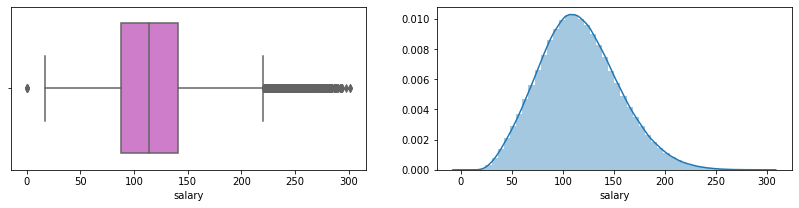

In [14]:
plt.figure(figsize = (14,3))
plt.subplot(1,2,1)
sns.boxplot(df_train.salary, color = 'orchid')
plt.subplot(1,2,2)
sns.distplot(df_train.salary)

In [15]:
# Use IQR rule to identify potential outliers
stat = df_train.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [16]:
df_train[df_train.salary < 8.5]

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,0,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,0,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,0,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,0,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,0,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


In [17]:
#remove data with zero salaries
df_train = df_train[df_train.salary != 0]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
salary                 999995 non-null int64
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [18]:
df_train[df_train.salary > 220.5]

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
266,JOB1362684407953,223,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60
362,JOB1362684408049,223,COMP38,CTO,MASTERS,NONE,HEALTH,24,3
560,JOB1362684408247,248,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7
670,JOB1362684408357,240,COMP26,CEO,MASTERS,MATH,AUTO,23,9
719,JOB1362684408406,225,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14
966,JOB1362684408653,247,COMP32,CEO,DOCTORAL,ENGINEERING,FINANCE,23,11
986,JOB1362684408673,229,COMP37,CFO,HIGH_SCHOOL,NONE,FINANCE,24,20
1211,JOB1362684408898,232,COMP24,CTO,DOCTORAL,BUSINESS,FINANCE,5,46
1222,JOB1362684408909,225,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5
1413,JOB1362684409100,241,COMP56,VICE_PRESIDENT,MASTERS,MATH,WEB,24,15


In [19]:
#check to see what job type people who make over $220,500 hold
df_train.loc[df_train.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

I wasn't expecting to see poeple who hold Junior positions making over $200,500. But I can see below that the industry is all finance and oil and one web which are high paying industries.

In [20]:
df_train[(df_train.salary > 220.5) & (df_train.jobType == 'JUNIOR')]

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
1222,JOB1362684408909,225,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5
27710,JOB1362684435397,246,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3
31355,JOB1362684439042,225,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0
100042,JOB1362684507729,248,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8
160333,JOB1362684568020,223,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3
189582,JOB1362684597269,221,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11
214606,JOB1362684622293,222,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4
303778,JOB1362684711465,226,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2
348354,JOB1362684756041,226,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25
427593,JOB1362684835280,221,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3


#### Visualize the feature variables
#### Visualize relationship between each feature and the target

In [21]:
def plot_feature(df, col):
    plt.figure(figsize = (16,6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace = True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Counts")
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                        alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
        
    plt.xticks(rotation=45)
    plt.ylabel("Salaries")
    plt.show()

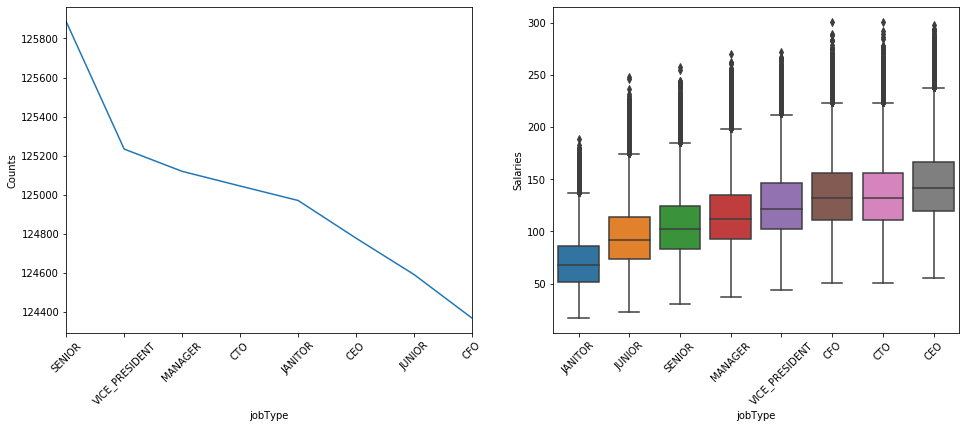

In [22]:
plot_feature(df_train, 'jobType')

There is a positive correlation between Job Type and Salary.

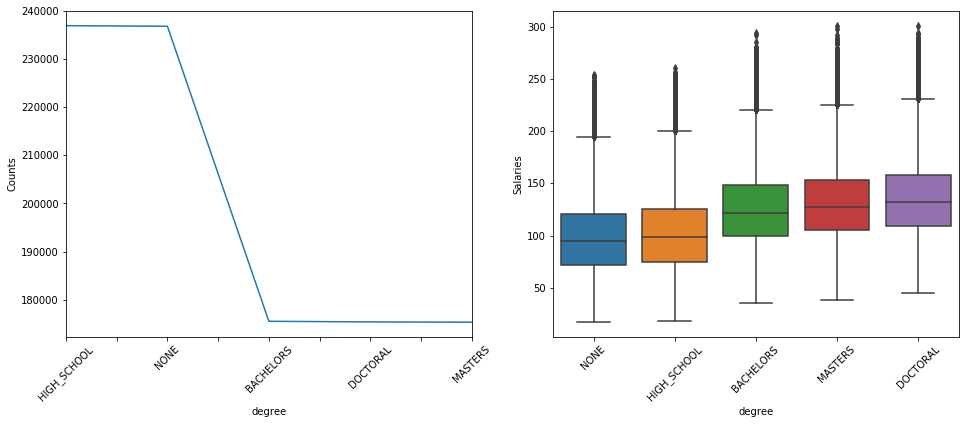

In [23]:
plot_feature(df_train, 'degree')

There is a positive correlation between Degree and Salary.

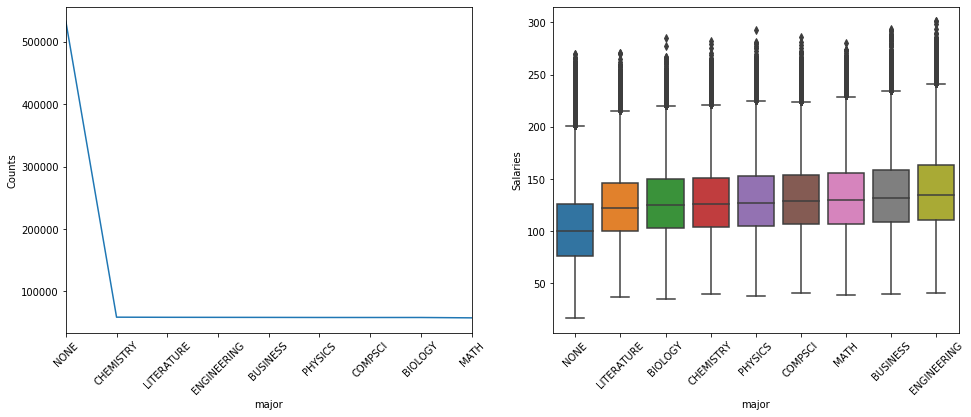

In [24]:
plot_feature(df_train, 'major')

Business and Engineering majors tend to have a higher average salary.

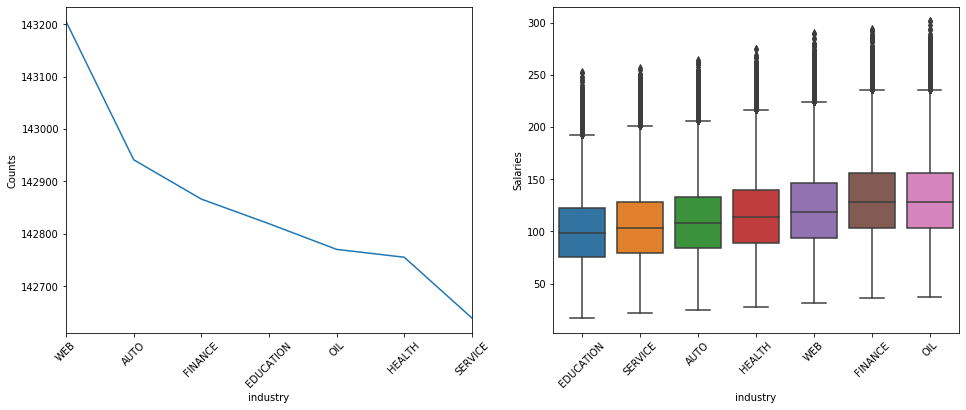

In [25]:
plot_feature(df_train, 'industry')

Web, Finance, and Oil industries tend to correspond to higher salaries. This confirms the outliers I saw earlier for junior level positions with high salaries.

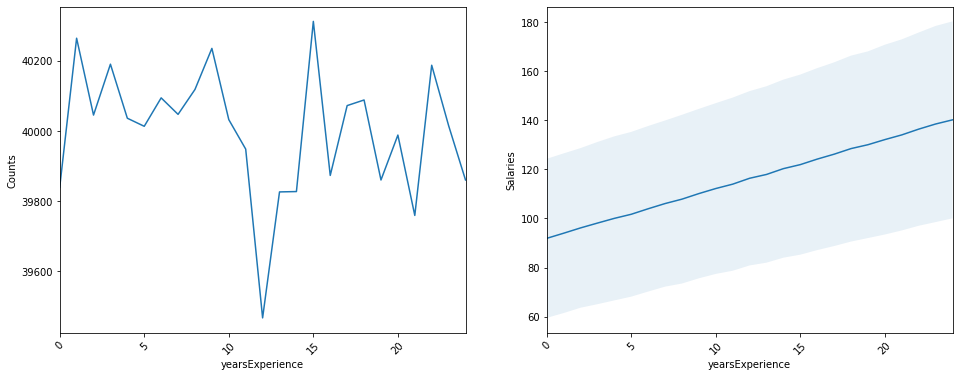

In [26]:
plot_feature(df_train, 'yearsExperience')

As expected, the more years of experience one has the higher the salary.

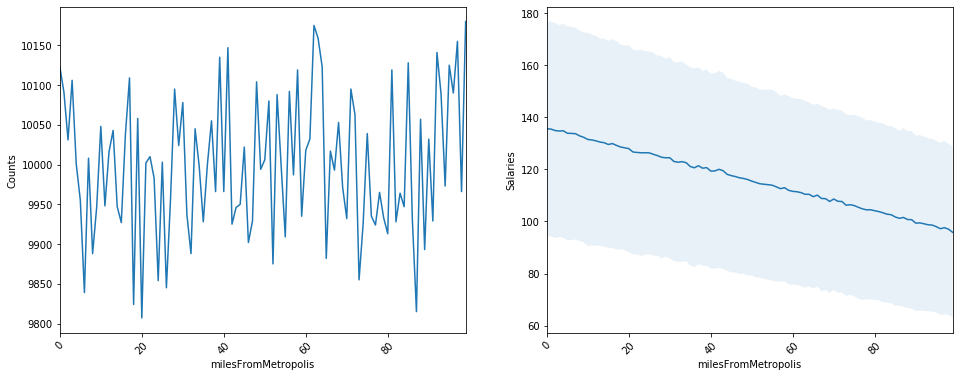

In [27]:
plot_feature(df_train, 'milesFromMetropolis')

Salaries decrease the further you are from a big city.

In [28]:
df_train.dtypes

jobId                    object
salary                    int64
companyId                object
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
dtype: object

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
salary                 999995 non-null int64
companyId              999995 non-null object
jobType                999995 non-null category
degree                 999995 non-null category
major                  999995 non-null category
industry               999995 non-null category
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
dtypes: category(4), int64(3), object(2)
memory usage: 89.6+ MB


In [30]:
#jobId is not included because it is a unique indentifier and companyId doesn't seeem to provide valuable information
cat_df = df_train.select_dtypes(include = ['category']).copy()
cat_df.head()

,jobType,degree,major,industry
0,CFO,MASTERS,MATH,HEALTH
1,CEO,HIGH_SCHOOL,NONE,WEB
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE


#### Look for correlation between features

In [31]:
def encode_label(df,col):
    cat_dict = {}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df_train[df_train[col] == cat]['salary'].mean()
    df[col] = df[col].map(cat_dict)

In [32]:
for col in df_train.columns:
    if df_train[col].dtype.name == "category":
        encode_label(df_train, col)

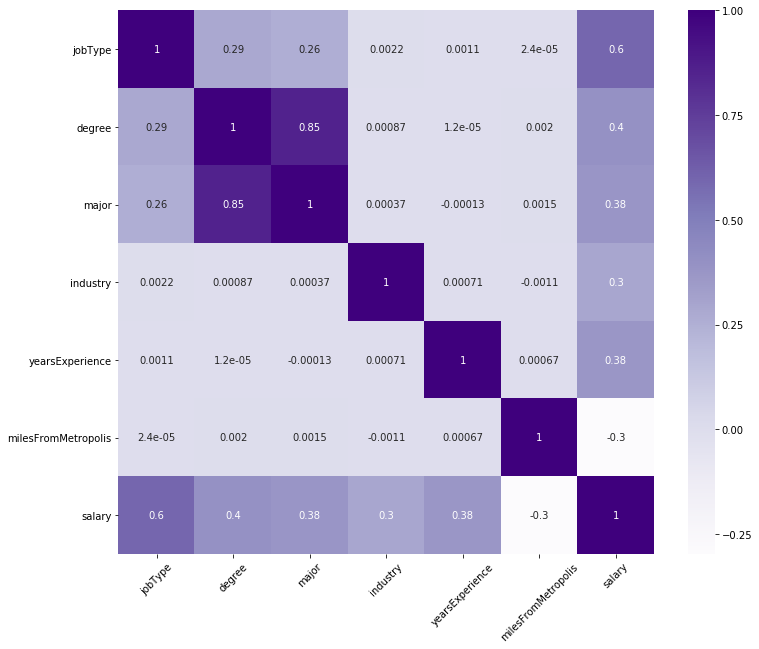

In [33]:
#correlations between selected features and responses
fig = plt.figure(figsize = (12,10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(df_train[features + ['salary']].corr(), cmap='Purples', annot=True)
plt.xticks(rotation=45)
plt.show()

Major and Degree show to have a strong positive correlation.

In [34]:
#Converting degree and jobType to ordinal variables
ordinal_cat_map = {'degree': {'NONE': 0, 'HIGH_SCHOOL': 1, 'BACHELORS': 2, 'MASTERS': 3, 'DOCTORAL': 4}, 
               'jobType': {'JANITOR':0, 'JUNIOR':1, 'SENIOR':2, 'MANAGER':3, 'VICE_PRESIDENT':4, 'CFO':5, 'CTO':6, 'CEO':7}}
cat_df.replace(ordinal_cat_map, inplace=True)

In [35]:
cat_df.head()

,jobType,degree,major,industry
0,5,3,MATH,HEALTH
1,7,1,NONE,WEB
2,4,4,PHYSICS,HEALTH
3,3,4,CHEMISTRY,AUTO
4,4,2,PHYSICS,FINANCE


In [36]:
#One-hot encode categorical data
cat_df = pd.get_dummies(cat_df, drop_first = True)

In [37]:
cat_df.head()

,jobType,degree,major_LITERATURE,major_BIOLOGY,major_CHEMISTRY,major_PHYSICS,major_COMPSCI,major_MATH,major_BUSINESS,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL
0,5,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,7,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,3,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [38]:
#created a new data set including encoded categorical and numerical features needed for modeling 
new_df_train = pd.concat([cat_df, df_train[['yearsExperience', 'milesFromMetropolis']]], axis=1)

In [39]:
new_df_train.head()

,jobType,degree,major_LITERATURE,major_BIOLOGY,major_CHEMISTRY,major_PHYSICS,major_COMPSCI,major_MATH,major_BUSINESS,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL,yearsExperience,milesFromMetropolis
0,5,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,10,83
1,7,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,73
2,4,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,10,38
3,3,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,8,17
4,4,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,8,16


### Establishing a baseline

In [40]:
#Feature Matrix
X = new_df_train
#Target Variable
y = df_train["salary"]

In [41]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                 1.556e+05
Date:                Mon, 16 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:36:59   Log-Likelihood:            -4.4076e+06
No. Observations:              999995   AIC:                         8.815e+06
Df Residuals:                  999976   BIC:                         8.815e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  51.1402      0.080    642.960      0.000      50.984      51.296
jobType                 8.7160      0.009    981.567      0.000       8.699       8.733
degree                  5.0293      0.022    225.385      0.000       4.986       5.073
major_LITERATURE        2.4303      0.100     24.372      0.000       2.235       2.626
major_BIOLOGY           6.0918      0.100     61.025      0.000       5.896       6.287
major_CHEMISTRY         7.1462      0.100     71.777      0.000       6.951       7.341
major_PHYSICS           8.3947      0.100     84.056      0.000       8.199       8.590
major_COMPSCI          10.0910      0.100    101.088      0.000       9.895      10.287
major_MATH             11.2273      0.100    112.025      0.000      11.031      11.424
major_BUSINESS         13.7744      0.100    138.020      0.000      13.579      13.970
major_ENGINEERING      16.6944      0.100    167.468      0.000      16.499      16.890
industry_SERVICE        5.0205      0.074     67.535      0.000       4.875       5.166
industry_AUTO           9.9912      0.074    134.471      0.000       9.846      10.137
industry_HEALTH        16.2697      0.074    218.902      0.000      16.124      16.415
industry_WEB           22.1113      0.074    297.732      0.000      21.966      22.257
industry_FINANCE       31.1512      0.074    419.209      0.000      31.006      31.297
industry_OIL           31.3078      0.074    421.245      0.000      31.162      31.453
yearsExperience         2.0100      0.003    730.008      0.000       2.005       2.015
milesFromMetropolis    -0.3995      0.001   -580.987      0.000      -0.401      -0.398
==============================================================================
Omnibus:                     7210.951   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7192.114
Skew:                           0.195   Prob(JB):                         0.00
Kurtosis:                       2.858   Cond. No.                         533.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
#Model Selection: Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['jobType', 'degree', 'major_LITERATURE', 'major_BIOLOGY', 'major_CHEMISTRY', 'major_PHYSICS', 'major_COMPSCI', 'major_MATH', 'major_BUSINESS', 'major_ENGINEERING', 'industry_SERVICE', 'industry_AUTO', 'industry_HEALTH', 'industry_WEB', 'industry_FINANCE', 'industry_OIL', 'yearsExperience', 'milesFromMetropolis']


In [44]:
#create training and test vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(799996, 18) (799996,)
(199999, 18) (199999,)


In [45]:
# apply standardization on numerical features

# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = ['jobType','degree','yearsExperience','milesFromMetropolis']

for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [46]:
#check if multicollinearity exists
vif = pd.DataFrame()
vif["features"] = X_train_stand.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train_stand.values, i) for i in range(X_train_stand.shape[1])]
vif

,features,VIF Factor
0,jobType,1.047471
1,degree,2.190637
2,major_LITERATURE,1.333238
3,major_BIOLOGY,1.330871
4,major_CHEMISTRY,1.333592
5,major_PHYSICS,1.330656
6,major_COMPSCI,1.329623
7,major_MATH,1.328180
8,major_BUSINESS,1.330073
9,major_ENGINEERING,1.330851


In [47]:
#fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train_stand, y_train)
y_hat = lm.predict(X_test_stand)
print("The first 5 predictied salaries: ", y_hat[0:5])

The first 5 predictied salaries:  [153.96898261  96.20195053 130.10698617  83.40480695 135.18805488]


Text(0, 0.5, 'Predictions')

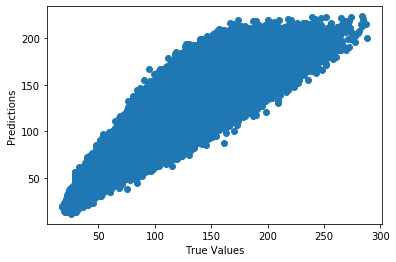

In [48]:
#plot the model
plt.scatter(y_test, y_hat)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [49]:
#print accuracy
print("Score:", model.score(X_test_stand, y_test))

Score: 0.735816039686696


In [50]:
#print MSE 
base_predictions = lm.predict(X_test_stand)
print('Mean Squared Error of our baseline prediction model:', mean_squared_error(y_test, y_hat))

Mean Squared Error of our baseline prediction model: 394.94801508813936


In [51]:
#accuracy of the baseline model using 5-cross validation method
score = cross_val_score(lm, X_train_stand, y_train, cv = 5)
print('5-Cross Validation accuracy:', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy: 0.7371693642828553 0.001100158839520273


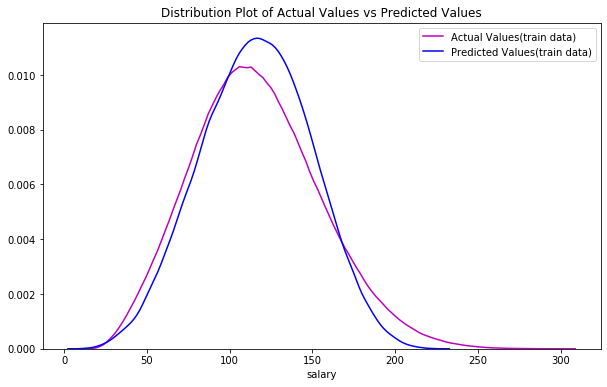

In [52]:
#distribution plot 
plt.figure(figsize=(10,6)) 
ax1 = sns.distplot(y, hist = False, color = 'm',label = 'Actual Values(train data)')
ax1 = sns.distplot(base_predictions, hist = False, color = 'b', label = 'Predicted Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values')
plt.show()

### Possible solutions

Models that may improve results over the baseline model
1. Try Polynomial Transformation: When I plotted the model previously, the data showed some curvature. If we applyed polynomial transformation to the features, a quadratic curve will potentionally fit the data better than a linear one.
2. Ridge Regression: Since the data potentially displays multicollinearity or highly corrleated features, specifically between major and degree, I decided to try this model.
3. Random Forest: Since the data consists of largely categorical features, I choose this model to see if it would perform better.

## DEVELOP

### Model 1: Polynomial Transformation Regression
#### Feature Engineering

In [53]:
#Fit and transform the variables with 2nd order (quadratic) polynomial
pr = PolynomialFeatures(2)
X_train_pr = pr.fit_transform(X_train_stand)
X_test_pr = pr.fit_transform(X_test_stand)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

#### Create model

In [54]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(X_train_pr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
#make predictions on training data
predictions_pr_train = poly.predict(X_train_pr)
#make predictions on test data
predictions_pr_test = poly.predict(X_test_pr)

#### Test model

In [56]:
#print R-squared values of training and test data 
print('R-squared of training data:', poly.score(X_train_pr, y_train))
print('R-squared of test data:', poly.score(X_test_pr, y_test))

R-squared of training data: 0.7618724406492992
R-squared of test data: 0.7609080065545804


In [57]:
#MSE of training and test data
print('MSE of training data:', mean_squared_error(y_train, predictions_pr_train))
print('MSE of test data:', mean_squared_error(y_test, predictions_pr_test))

MSE of training data: 357.1979647631412
MSE of test data: 357.43619000467993


### Model 2: Ridge Regression
#### Create Model

In [58]:
#create a ridge regression object and fit it to training data 
RidgeModel = Ridge(alpha = 1)
RidgeModel.fit(X_train_pr, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [59]:
#predict values of training data and test data
predictions_Ridge_train = RidgeModel.predict(X_train_pr)
predictions_Ridge_test = RidgeModel.predict(X_test_pr)

#### Test Model

In [60]:
#MSE of training and test data
print('MSE of training data:', mean_squared_error(y_train, predictions_Ridge_train))
print('MSE of test data:', mean_squared_error(y_test, predictions_Ridge_test))

MSE of training data: 357.1884804319906
MSE of test data: 357.41591824728283


No improvement in MSE

We will introduce GridSearchCV for ridge regression in order to automatically perform 5-fold cross-validation with a range of different parameters to find the optimal value of alpha.

In [61]:
ridge = Ridge()
parameters = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
ridge_regressor = GridSearchCV(ridge, parameters, cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [62]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.1}
0.7371693645298207


Ridge Regression showed no improvement. Result showed same alpha previously used.

### 3. Random Forest
#### Create Model

In [63]:
#Instantiate model with 150 decision trees
rf = RandomForestRegressor(n_estimators = 150, max_depth = 20, min_samples_leaf = 10, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

#### Test Model

In [64]:
#Make predictions on test data 
predictions_rf_test = rf.predict(X_test)
#R-squared and MSE of test data 
print('R-squared of test data: ', rf.score(X_test, y_test))
print('MSE of test data:', mean_squared_error(y_test, predictions_rf_test))

R-squared of test data:  0.7513411723472182
MSE of test data: 371.73835345318776


### Selecting best model

I evaluated the model based on MSE and R-squared.
<br>
R-squared: the percentage of variation of the dependent variable that is explained by our independent variables.
<br>
Mean Squared Error (MSE): measures the average of the squares of errors, which is, the difference between the estimated value and the actual value.


**Linear regression with 2nd order polynomial transformation gave the best prediction of salary with MSE of 357 and R-squared of 76%.**
<br>
*Ridge Regression also showed MSE of 357, but a R-squared of slightly lower at 73%. 
<br>
Random Forest resulted in the worse MSE of 372 and R-squared of 75%.*

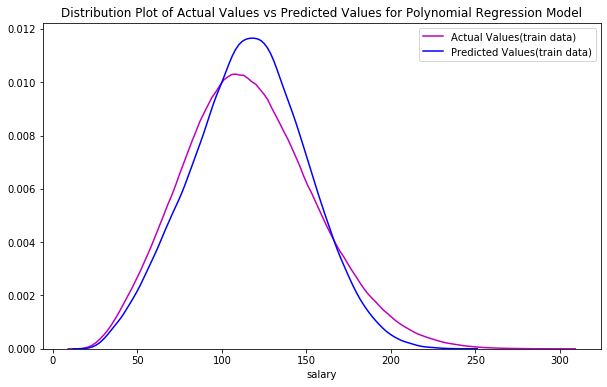

In [65]:
#distribution plot of the selected model
plt.figure(figsize=(10,6))
ax1 = sns.distplot(y_train, hist = False, color = 'm',label = 'Actual Values(train data)')
ax1 = sns.distplot(predictions_pr_test, hist = False, color = 'b', label = 'Predicted Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values for Polynomial Regression Model')
plt.show()

## DEPLOY

### Automate pipeline

In [66]:
#create pipeline for polynomial regression 
input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)), ('model', LinearRegression())]
pipe = Pipeline(input)

In [67]:
#fit the pipeline to the entire training data 
poly_LR_model = pipe.fit(X, y)

In [68]:
#make predictions on the test data and print first five 
y_hat_pipe = pipe.predict(X)
y_hat_pipe[0:5]

array([124.13671875, 115.3671875 , 135.00390625, 122.078125  ,
       142.54296875])

### Deploy solution

In [69]:
#save prediction to a csv file
filename = 'Salary_prediction.csv'
joblib.dump(poly_LR_model, filename)

['Salary_prediction.csv']

In [70]:
#load model 
loaded_model = joblib.load(filename)

In [71]:
#see results of test data with known salaries
result = loaded_model.score(X_test, y_test)
print(result)

0.760984623588973


In [72]:
df_test_features = pd.DataFrame(df_test_features)

In [73]:
#save continuous variables to separate dataframe to save space for encoding of categorical features in next step
df_test_int_features = df_test_features[['yearsExperience', 'milesFromMetropolis']]

In [74]:
#save categorical variables to separate dataframe to save space for encoding of categorical features in next step
#select only variables that are essential to the model
df_test_cat_features = df_test_features[['jobType', 'degree', 'major', 'industry']]

In [75]:
#Converting degree and jobType to ordinal variables
ordinal_cat_map = {'degree': {'NONE': 0, 'HIGH_SCHOOL': 1, 'BACHELORS': 2, 'MASTERS': 3, 'DOCTORAL': 4}, 
               'jobType': {'JANITOR':0, 'JUNIOR':1, 'SENIOR':2, 'MANAGER':3, 'VICE_PRESIDENT':4, 'CFO':5, 'CTO':6, 'CEO':7}}
df_test_cat_features.replace(ordinal_cat_map, inplace=True)

In [76]:
#One-hot encode categorical features
df_test_cat_features = pd.get_dummies(df_test_cat_features, drop_first = True)

In [77]:
#create one dataframe for all features used in the model
test_features_df = pd.concat([df_test_int_features, df_test_cat_features], axis=1)

In [78]:
predictions = loaded_model.predict(test_features_df)

In [79]:
#Tree Model (for Regression & Classification)
model = DecisionTreeRegressor()
# fit the model
model.fit(X, y)
#get importance
importance = model.feature_importances_

importance_df = pd.DataFrame(importance, index=X.columns)
#sort values
importance_df.columns = ['Importance']
importance_df.sort_values(by="Importance", ascending = False, inplace = True)
importance_df

,Importance
jobType,0.345526
milesFromMetropolis,0.198117
yearsExperience,0.191852
degree,0.119560
industry_FINANCE,0.030598
industry_OIL,0.030260
industry_WEB,0.016679
industry_HEALTH,0.009627
major_ENGINEERING,0.008518
major_BUSINESS,0.007257


Text(0.5, 1.0, 'Feature Importance for Salary Prediction')

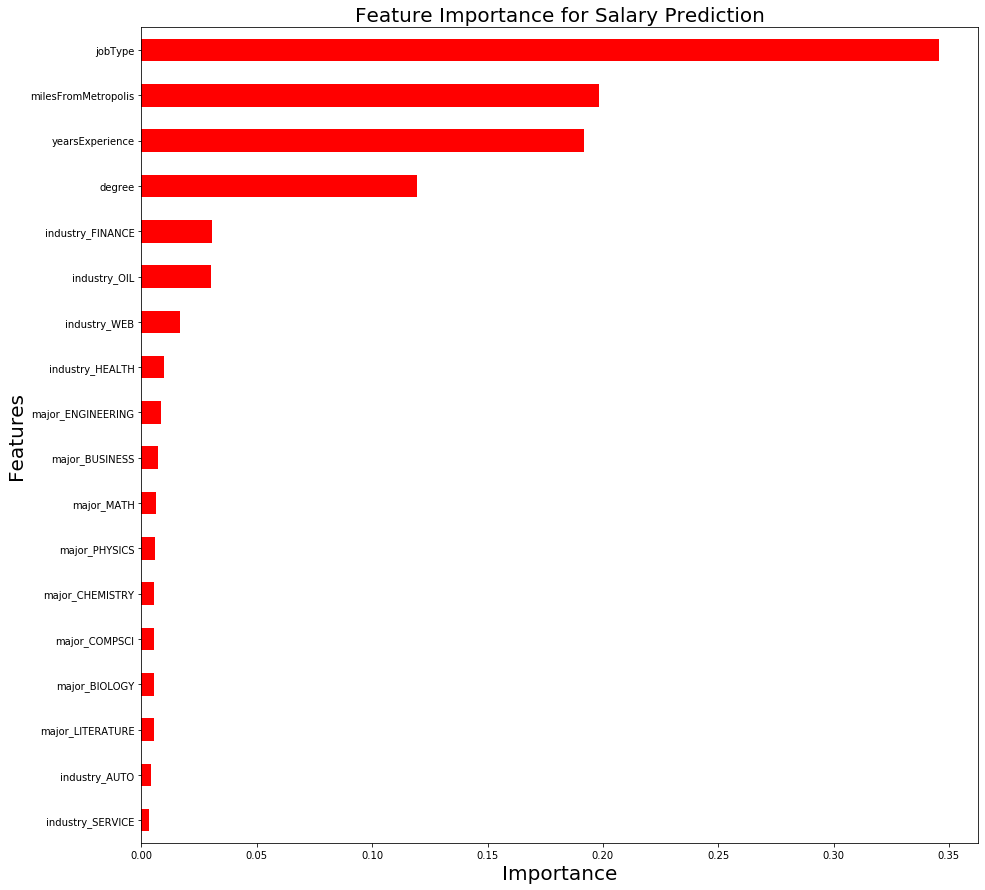

In [80]:
plt.figure()
ax1 = importance_df['Importance'].sort_values().plot(kind='barh', figsize=(15,15), color = 'r')
ax1.set_ylabel('Features',fontdict={'fontsize':20})
ax1.set_xlabel('Importance',fontdict={'fontsize':20})
plt.rcParams.update({'font.size': 15})
ax1.set_title("Feature Importance for Salary Prediction", fontdict={'fontsize':20})